In [2]:
#pip install pyod scikit-learn matplotlib pandas

In [24]:
#!pip install shap

## Step 1: Loading and Preprocessing the Data

In this step, we're importing the neccessary libraries and loading the avocado dataset and selecting relevant features for our anomaly detection task.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from pyod.models.iforest import IForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.utils import resample
import matplotlib.pyplot as plt
import shap

In [36]:
# Load the dataset
df = pd.read_csv('avocado.csv')

In [37]:
df.drop(columns = 'Unnamed: 0', inplace= True)

In [38]:
# Selecting the relevant features for anomaly detection
features = ['AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags']

In [39]:
X = df[features]

## Step 2: Scaling and Splitting the Data

Here, we standardize the data to ensure all features are on the same scale, then split it into training and test sets.

In [40]:
# Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(X)

In [41]:
# Split into train and test sets
X_train, X_test = train_test_split(features_scaled, test_size=0.3, random_state=42)

In [46]:
features_scaled

array([[-0.18868864, -0.22771641, -0.23081597, -0.1999022 , -0.21209136,
        -0.23417028],
       [-0.13901962, -0.23042664, -0.23110251, -0.20805446, -0.21199672,
        -0.23335029],
       [-1.18206895, -0.21208462, -0.23100731, -0.1544779 , -0.21132513,
        -0.23472951],
       ...,
       [ 1.15237477, -0.24233073, -0.2306933 , -0.24309014, -0.20576554,
        -0.2334633 ],
       [ 1.30138182, -0.24162464, -0.2304279 , -0.24265143, -0.20577419,
        -0.23186585],
       [ 0.53151208, -0.24125273, -0.22934712, -0.24317042, -0.21045012,
        -0.23080663]])

 ## Step 3: Implementing Isolation Forest for Anomaly Detection

In this step, we initialize and train the Isolation Forest model on our data. We'll then use this model to predict anomalies in our test set. Let's break down the process and the key parameters:

In [8]:
# Initialize the Isolation Forest model
iforest = IsolationForest(n_estimators = 100, contamination = 0.03, max_samples ='auto') 

In [9]:
# Train the model on the training data
iforest.fit(X_train)

IsolationForest(contamination=0.03)

In [10]:
# Predict anomalies on the test set
y_test_pred = iforest.predict(X_test)

In [11]:
y_test_pred

array([1, 1, 1, ..., 1, 1, 1])

Here's what each parameter in our model initialization means:

n_estimators = 100: This sets the number of trees in our forest. Having 100 trees provides a good balance between model performance and computational efficiency.

contamination = 0.03: This parameter represents the expected proportion of anomalies in our dataset. We've set it to 3%, suggesting we anticipate about 3% of our avocado sales data points to be anomalous.

max_samples ='auto': This determines the number of samples used to train each base estimator. The 'auto' setting uses the minimum of 256 or the total number of samples, helping to balance between computational speed and model accuracy.

After fitting the model to our training data, we use it to predict anomalies in the test set. The predict method returns an array where:

-1 indicates an anomaly

1 indicates a normal data point

This binary classification makes it easy to identify which avocado sales data points the model considers unusual or potentially problematic. These could be instances of unexpectedly high or low prices, unusual sales volumes, or other patterns that deviate significantly from the norm in our dataset.

Please take a look at Isolation Forest documentation in sklearn to understand more about the model parameters.

## Step 4: Visualizing Anomalies

Now that we've identified anomalies, let's visualize the them detected by our model. The scatter plot shows normal data points in blue and anomalies in red based on "Average Price" and "Total Volume". We can see that anomalies tend to be on the outskirts of the data distribution and they are easily isolatable data points. 

In [12]:
# Fetching the index of the anomaly data points in the test set
anomaly_index = np.where(y_test_pred == -1)[0]

In [13]:
# Extracting anomaly data points using numpy indexing
anomalies = X_test[anomaly_index]

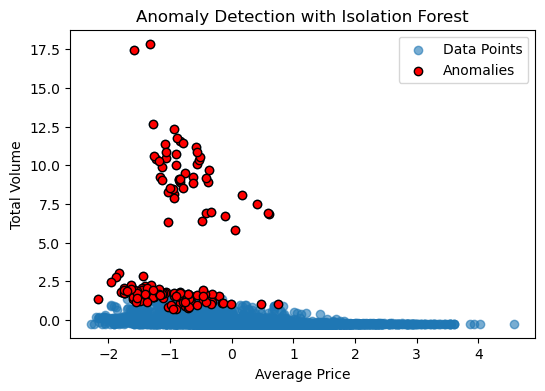

In [14]:
#Plotting the data points and anomalies (after scaling)
plt.figure(figsize=(6, 4))
plt.scatter(X_test[:, 0], X_test[:, 1], label='Data Points', alpha=0.6)
# Highlight the anomalies using the index of anomalies from predictions
plt.scatter(X_test[anomaly_index, 0], X_test[anomaly_index, 1],color='red', edgecolors="k", label='Anomalies')


plt.xlabel('Average Price')
plt.ylabel('Total Volume')
plt.title('Anomaly Detection with Isolation Forest')
plt.legend()
plt.show()

Most of the normal data points are densely packed in the bottom-left corner of the graph (close to zero values for both "Average Price" and "Total Volume").

The anomalies (red dots) are scattered across the plot but are particularly visible in regions where the total volume or the average price is significantly higher than the cluster of normal points. This implies that instances with unusually high prices or volumes are flagged as outliers.

There's also a pattern where the anomalies occur at relatively higher "Total Volume" values for lower "Average Price" values, suggesting that combinations of low prices and high volumes might be considered atypical in this dataset.

Now let's dive a little deeper by calculating anomaly scores for each data point using the decision_function() method. These scores give us a more nuanced view of how 'anomalous' or abnormal each point is, rather than just a binary classification.

In [15]:
# Converting the scaled test set back into a DataFrame with feature names for easier access
X_test_df = pd.DataFrame(X_test, columns=features)

# Calculating anomaly scores using the Isolation Forest model
score = iforest.decision_function(X_test)

# Creating a DataFrame to display the 'Total Volume', 'AveragePrice', and corresponding anomaly scores
data_scores = pd.DataFrame(list(zip(X_test_df['Total Volume'], X_test_df['AveragePrice'], score)), 
                           columns=['Total Volume', 'Average Price', 'Anomaly Score'])

data_scores.head()


,Total Volume,Average Price,Anomaly Score
0,-0.183096,-1.455249,0.266400
1,-0.132948,-1.082731,0.266812
2,-0.245186,0.084491,0.312822
3,-0.168727,-1.082731,0.274928
4,-0.243767,0.109325,0.311944


Highlighting the top 10 most extreme anomalies based on these scores. This focused view will draw our attention to the most significant outliers in our avocado sales data.

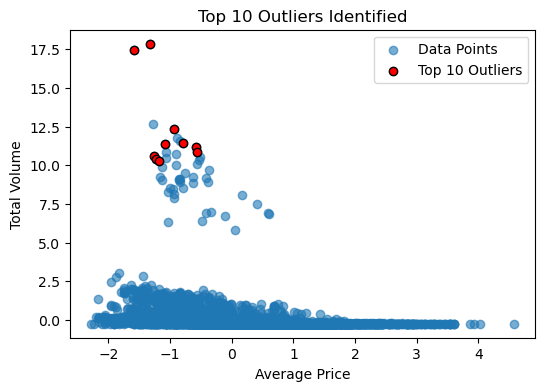

In [16]:
# Sort by anomaly score and get the top 10 outliers
top_10_outliers = data_scores.sort_values(by=['Anomaly Score']).head(10)

# Plot all data points and highlight the top 10 outliers
plt.figure(figsize=(6, 4))
plt.scatter(X_test_df['AveragePrice'], X_test_df['Total Volume'], label='Data Points', alpha=0.6)
plt.scatter(top_10_outliers['Average Price'], top_10_outliers['Total Volume'], color='red', label='Top 10 Outliers', edgecolor='k')

plt.title("Top 10 Outliers Identified")
plt.xlabel('Average Price')
plt.ylabel('Total Volume')
plt.legend()
plt.show()


Through these visualizations, we aim to uncover insights about unusual pricing or sales volumes in our dataset, potentially revealing interesting market trends or data collection issues.

## Step 5: Flagging and Analyzing Anomalous Records

In this step, we identify and flag the specific records marked as anomalies by our Isolation Forest model. This allows for easy access to these abnormal data points for any potential further analysis in the future.

In [17]:
# Inverse transform the scaled data to get the original feature values for X_test
X_test_inverse = scaler.inverse_transform(X_test)

In [18]:
# Convert the inverse-scaled data back to a DataFrame for easier readability
X_test_df = pd.DataFrame(X_test_inverse, columns=features)

In [19]:
# Add a column to X_test_df to indicate anomalies (1 for anomaly, 0 for normal)
X_test_df['Anomaly'] = np.where(y_test_pred < 1, 'Anomaly', 'Normal')

In [20]:
# Fetching the anomalous rows
anomalies_main_df = X_test_df[X_test_df['Anomaly'] == 'Anomaly']
anomalies_main_df.head(2)

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Anomaly
7,0.94,32804733.22,10015825.13,12003751.56,1375260.47,9409896.06,Anomaly
46,1.14,4759791.13,1702965.49,2230693.51,273922.36,552209.77,Anomaly


In [21]:
num_of_normal = (X_test_df == 'Nomral').count()
num_of_anomalies = (X_test_df == 'Anomaly').count()
print(f"Total number of anomalies detected: {num_of_anomalies}")
print(f"Total number of non-anomalies detected: {num_of_normal}")

Total number of anomalies detected: AveragePrice    5475
Total Volume    5475
4046            5475
4225            5475
4770            5475
Total Bags      5475
Anomaly         5475
dtype: int64
Total number of non-anomalies detected: AveragePrice    5475
Total Volume    5475
4046            5475
4225            5475
4770            5475
Total Bags      5475
Anomaly         5475
dtype: int64


In [22]:
num_of_normal = (y_test_pred == 1).sum()
num_of_anomalies = (y_test_pred == -1).sum()
print(f"Total number of anomalies detected: {num_of_anomalies}")
print(f"Total number of non-anomalies detected: {num_of_normal}")

Total number of anomalies detected: 153
Total number of non-anomalies detected: 5322


## Step 6: Interpreting Results Using SHAP

Here, we're taking a random sample of 100 rows from the test dataset (X_test) is selected to compute SHAP values.

This step reduces the computation cost for SHAP (SHapley Additive exPlanations) calculations, which can be expensive when dealing with large datasets. By using a smaller sample, we can make the SHAP calculations more efficient while maintaining enough data to approximate the model’s behavior.

In [23]:
# Reduce the background samples from X_train (e.g., 100 rows)
X_train_sample = resample(X_train, n_samples=100, random_state=42)

In [24]:
# Re-initialize the SHAP explainer with the reduced background
explainer = shap.KernelExplainer(iforest.decision_function, X_train_sample)

In [25]:
# Use a smaller subset of X_test to compute SHAP values (e.g., 100 rows)
X_test_sample =  resample(X_test, n_samples=100, random_state=42)

In [26]:
# Compute SHAP values for the test data
shap_values = explainer.shap_values(X_test_sample)

  0%|          | 0/100 [00:00<?, ?it/s]

In [47]:
print(X_test_sample.shape)
print(shap_values.shape)

(100, 6)
(100, 6)


This line creates a SHAP summary plot to visualize how much impact each feature has on the model’s output. The plot shows the distribution of SHAP values for each feature and indicates whether higher or lower values of each feature increase or decrease the likelihood of a data point being classified as an outlier.

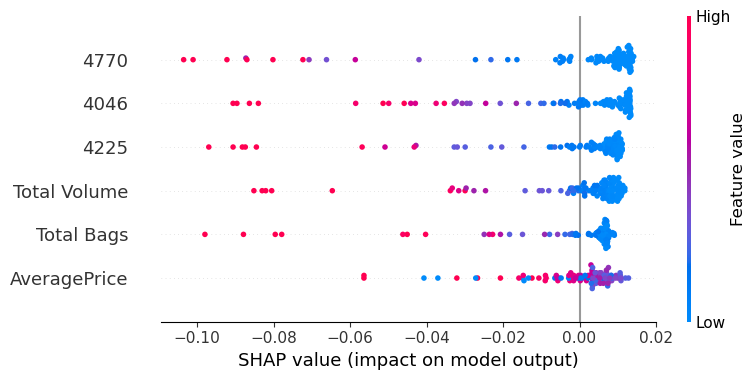

In [32]:
# Visualize SHAP summary
shap.summary_plot(shap_values, X_test_sample, feature_names=features)

Y-axis (Features): The features are listed in order of importance, from top to bottom, indicating which features have the most influence on the model's predictions.

X-axis (SHAP Value): SHAP values show how much a feature affects the prediction. A positive SHAP value pushes the prediction toward anomalous, while a negative SHAP value pushes it toward non-anomalous. The farther a point is from zero, the stronger the feature's influence.

Color (Feature Value): The color gradient from blue (low feature value) to red (high feature value) represents the actual value of the feature for each data point. For instance, in the feature "4770", higher values (red) tend to have negative SHAP values, meaning high values of this feature push the prediction toward being non-anomalous. In contrast, lower values (blue) have more positive SHAP values, increasing the likelihood of the data point being flagged as an anomaly.

Interpretation: Each dot is a data point. For example, for the feature "4770", higher values (red dots) generally reduce the chances of an anomaly, as they have negative SHAP values. On the other hand, lower values of "4770" (blue dots) increase the likelihood of an anomaly.

Features like 4770 and Total Bags offer consistent signals, meaning their impact on anomaly detection is stable and predictable. For instance, higher values of these features might consistently push the model toward labeling a data point as non-anomalous, while lower values push it towards detecting an anomaly. This predictability makes them reliable indicators for the model when deciding whether a data point is an outlier or not.

On the other hand, Total Volume and AveragePrice show a wider spread of SHAP values, meaning their influence on predictions varies depending on their specific values. This variability allows the model to be more flexible and context-driven, adjusting its anomaly detection decisions based on the particular values of these features in different instances.

In summary, 4770 and Total Bags provide clear, consistent guidance for anomaly detection, while Total Volume and AveragePrice offer more context-dependent insights that help the model detect more nuanced or situational anomalies.

##  Step 7: Exploring Feature Importance with SHAP Values

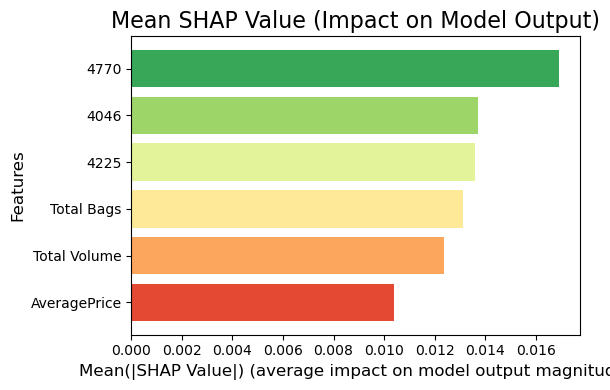

In [70]:
num_features = X_test.shape[1]

# Get the mean absolute SHAP value for each feature
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# Sort the features by mean SHAP values in ascending order
sorted_idx = np.argsort(mean_shap_values)
sorted_mean_shap_values = mean_shap_values[sorted_idx]
sorted_feature_names = [features[i] for i in sorted_idx]

# Plot the mean SHAP values as a bar plot
fig, ax = plt.subplots(figsize=(6, 4))

# Define a diverging color palette
palette = sns.color_palette("RdYlGn", num_features)

# Create the bar plot
bars = ax.barh(range(num_features), sorted_mean_shap_values, color=palette)

# Add title and labels
ax.set_title("Mean SHAP Value (Impact on Model Output)", fontsize=16)
ax.set_xlabel("Mean(|SHAP Value|) (average impact on model output magnitude)", fontsize=12)
ax.set_ylabel("Features", fontsize=12)

# Set y-tick labels to feature names
ax.set_yticks(range(num_features))
ax.set_yticklabels(sorted_feature_names)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

plt.show()

The SHAP chart ranks features based on their average impact on the model. "4770" and "Total Bags" show the most consistent influence, indicating that they are reliable for distinguishing between normal and anomalous data.

On the other hand, "Total Volume" and "AveragePrice" show more spread in their SHAP values. This variability means their effect changes depending on their specific values, offering flexibility for detecting more context-specific anomalies.

How This Helps in Anomaly Detection:

SHAP values provide a breakdown of how each feature contributes to the model’s decisions, making the process transparent and interpretable. Features with high SHAP values, like "4770," act as consistent signals, while features with variable SHAP values, like "AveragePrice," allow the model to adapt to different scenarios, identifying complex patterns.

By explaining why certain data points are flagged as anomalies, SHAP values make predictions easier to trust, enabling better business decisions and allowing for more actionable insights.